__Pipeline 3 - Complex Source__

So far, we've not paid much attention to the source galaxy's morphology. We've assumed its a single-component exponential profile, which is a fairly crude assumption. A quick look at any image of a real galaxy reveals a wealth of different structures that could be present - bulges, disks, bars, star-forming knots and so on. Furthermore, there could be more than one source-galaxy!

In this example, we'll explore how far we can get trying to_fit a complex source using a pipeline. Fitting complex source's is an exercise in diminishing returns. Each component we add to our source model brings with it an extra 5-7, parameters. If there are 4 components, or multiple galaxies, we're quickly entering the somewhat nasty regime of 30-40+ parameters in our non-linear search. Even with a pipeline, thats a lot of parameters to try and fit!

In [ ]:
import autofit as af
from autolens.data import ccd
from autolens.data import simulated_ccd
from autolens.data.array import mask as msk
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.model.galaxy import galaxy as g
from autolens.lens import lens_data as ld
from autolens.lens import ray_tracing
from autolens.lens import lens_fit
from autolens.data.plotters import ccd_plotters
from autolens.lens.plotters import lens_fit_plotters

Lets setup the path to the workspace, as per usual.

In [ ]:
# If you arn't using docker, you need to change the path below to the chapter 3 directory and uncomment it
# workspace_path = '/path/to/workspace/'

af.conf.instance = af.conf.Config(
    config_path=workspace_path + "config", output_path=workspace_path + "output"
)

NameError: name 'workspace_path' is not defined

This function simulates an image with a complex source.

In [ ]:
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.from_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grid_stack = grids.GridStack.from_shape_pixel_scale_and_sub_grid_size(
        shape=(180, 180), pixel_scale=0.05, sub_grid_size=2
    )

    lens_galaxy = g.Galaxy(
        redshift=0.5,
        mass=mp.EllipticalIsothermal(
            centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0, einstein_radius=1.6
        ),
    )

    source_galaxy_0 = g.Galaxy(
        redshift=1.0,
        light=lp.EllipticalSersic(
            centre=(0.1, 0.1),
            axis_ratio=0.8,
            phi=90.0,
            intensity=0.2,
            effective_radius=1.0,
            sersic_index=1.5,
        ),
    )

    source_galaxy_1 = g.Galaxy(
        redshift=1.0,
        light=lp.EllipticalSersic(
            centre=(-0.25, 0.25),
            axis_ratio=0.7,
            phi=45.0,
            intensity=0.1,
            effective_radius=0.2,
            sersic_index=3.0,
        ),
    )

    source_galaxy_2 = g.Galaxy(
        redshift=1.0,
        light=lp.EllipticalSersic(
            centre=(0.45, -0.35),
            axis_ratio=0.6,
            phi=90.0,
            intensity=0.03,
            effective_radius=0.3,
            sersic_index=3.5,
        ),
    )

    source_galaxy_3 = g.Galaxy(
        redshift=1.0,
        light=lp.EllipticalSersic(
            centre=(-0.05, -0.0),
            axis_ratio=0.9,
            phi=140.0,
            intensity=0.03,
            effective_radius=0.1,
            sersic_index=4.0,
        ),
    )

    tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
        galaxies=[lens_galaxy],
        galaxies=[
            source_galaxy_0,
            source_galaxy_1,
            source_galaxy_2,
            source_galaxy_3,
        ],
        image_plane_grid_stack=image_plane_grid_stack,
    )

    return simulated_ccd.SimulatedCCDData.from_tracer_and_exposure_arrays(
        tracer=tracer,
        pixel_scale=0.05,
        exposure_time=300.0,
        psf=psf,
        background_sky_level=0.1,
        add_noise=True,
    )

Lets simulate the image.

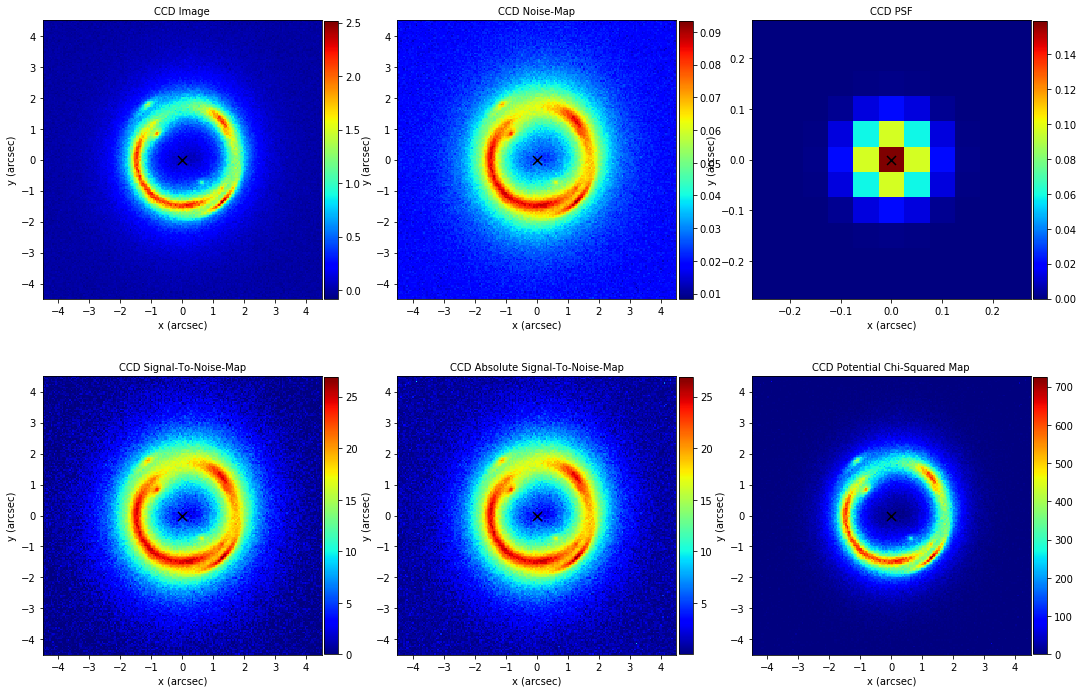

In [ ]:
ccd_data = simulate()
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)

Yep, that's a pretty complex source. There are clearly more than 4 peaks of light - I wouldn't like to guess whether there is one or two sources (or more). You'll also notice I omitted the lens galaxy's light for this system, this is to keep the number of parameters down and the phases running fast, but we wouldn't get such a luxury in a real galaxy.

Again, before we checkout the pipeline, lets import it, and get it running.

In [6]:
from workspace.howtolens.chapter_3_pipelines import tutorial_3_pipeline_complex_source

pipeline_complex_source = tutorial_3_pipeline_complex_source.make_pipeline(
    phase_folders=['howtolens', 'c3_t3_complex_source'])

pipeline_complex_source.run(data=ccd_data)

Okay, so with 4 sources, we still couldn't get a good a fit to the source that didn't leave residuals. The thing is, I did infact simulate the lens with 4 sources. This means that there is a 'perfect fit', somewhere in that parameter space, that we unfortunately missed using the pipeline above.

Lets confirm this, by manually fitting the ccd data with the true input model.

In [ ]:
lens_data = ld.LensData(
    ccd_data=ccd_data,
    mask=msk.Mask.circular(
        shape=ccd_data.shape, pixel_scale=ccd_data.pixel_scale, radius_arcsec=3.0
    ),
)

lens_galaxy = g.Galaxy(
    redshift=0.5,
    mass=mp.EllipticalIsothermal(
        centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0, einstein_radius=1.6
    ),
)

source_galaxy_0 = g.Galaxy(
    redshift=1.0,
    light=lp.EllipticalSersic(
        centre=(0.1, 0.1),
        axis_ratio=0.8,
        phi=90.0,
        intensity=0.2,
        effective_radius=1.0,
        sersic_index=1.5,
    ),
)

source_galaxy_1 = g.Galaxy(
    redshift=1.0,
    light=lp.EllipticalSersic(
        centre=(-0.25, 0.25),
        axis_ratio=0.7,
        phi=45.0,
        intensity=0.1,
        effective_radius=0.2,
        sersic_index=3.0,
    ),
)

source_galaxy_2 = g.Galaxy(
    redshift=1.0,
    light=lp.EllipticalSersic(
        centre=(0.45, -0.35),
        axis_ratio=0.6,
        phi=90.0,
        intensity=0.03,
        effective_radius=0.3,
        sersic_index=3.5,
    ),
)

source_galaxy_3 = g.Galaxy(
    redshift=1.0,
    light=lp.EllipticalSersic(
        centre=(-0.05, -0.0),
        axis_ratio=0.9,
        phi=140.0,
        intensity=0.03,
        effective_radius=0.1,
        sersic_index=4.0,
    ),
)

tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
    galaxies=[lens_galaxy],
    galaxies=[
        source_galaxy_0,
        source_galaxy_1,
        source_galaxy_2,
        source_galaxy_3,
    ],
    image_plane_grid_stack=lens_data.grid_stack,
)

true_fit = lens_fit.LensDataFit.for_data_and_tracer(lens_data=lens_data, tracer=tracer)

lens_fit_plotters.plot_fit_subplot(
    fit=true_fit.most_likely_fit,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

lens_fit_plotters.plot_fit_subplot_of_planes(
    fit=true_fit.most_likely_fit,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

NameError: name 'ld' is not defined

And indeed, we see far improved residuals, chi-squareds, etc.

The morale of this story is that, if the source morphology is complex, there is no way we can build a pipeline to fit it. For this tutorial, this was true even though our source model could actually fit the data perfectly. For real lenses, the source will be *even more complex* and there is even less hope of getting a good fit :(

But fear not, PyAutoLens has you covered. In chapter 4, we'll introduce a completely new way to model the source galaxy, which addresses the problem faced here. But before that, in the next tutorial we'll discuss how we actually pass priors in a pipeline.